In [5]:
# import the master.xlsx file and store it in pandas dataframe
import pandas as pd
import numpy as np
from pandasql import sqldf
# load the excel file
df = pd.read_excel('master.xlsx')

df = df.astype(str)
# drop the column HDI for year
df = df.drop('HDI for year', axis=1)
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,2156624900,796,Boomers


In [6]:
numDims = df.shape[1]
minSupport = 20
cardinality = []

# get the cardinality of each dimension
for i in range(numDims):
    cardinality.append(len(df.iloc[:,i].unique()))

# arrange the dataframes colums in the descending order of cardinality
df = df.iloc[:,np.argsort(cardinality)[::-1]]

cardinality = []
for i in range(numDims):
    cardinality.append(len(df.iloc[:,i].unique()))


df.head()

,population,suicides/100k pop,gdp_for_year ($),country-year,gdp_per_capita ($),suicides_no,country,year,generation,age,sex
0,312900,6.71,2156624900,Albania1987,796,21,Albania,1987,Generation X,15-24 years,male
1,308000,5.19,2156624900,Albania1987,796,16,Albania,1987,Silent,35-54 years,male
2,289700,4.83,2156624900,Albania1987,796,14,Albania,1987,Generation X,15-24 years,female
3,21800,4.59,2156624900,Albania1987,796,1,Albania,1987,G.I. Generation,75+ years,male
4,274300,3.28,2156624900,Albania1987,796,9,Albania,1987,Boomers,25-34 years,male


In [7]:
def write_file(start, end, val, count, cdf):
    
    file_name = "output/" + str(start) + "-" + str(end) + ".txt"

    with open(file_name,"a") as file:
        file.write(str(val) + " " + str(count) + "\n")



def BUC(cdf, start, end, do_write):

    if(end >= numDims):
        return
    countdf = sqldf(f'select \"{cdf.columns[end]}\", COUNT(*) as count from cdf group by \"{cdf.columns[end]}\" order by COUNT(*) DESC',locals())
    # return countdf
    
    # traverse the countdf and use recursive buc
    for i in range(len(countdf)):
        if countdf.iloc[i,1] >= minSupport:

            val = countdf.iloc[i,0]
            tempdf = sqldf(f'select * from cdf where \"{cdf.columns[end]}\" = \"{countdf.iloc[i,0]}\" LIMIT 1',locals())

            # only consider coloums from start to end
            tempdf = tempdf.iloc[:,start:end+1]

            # get the first row of the tempdf
            tempdf = tempdf.iloc[0,:]

            # append all the coloums in tempdf to a string separated by ~
            tempdf = " ~ ".join(tempdf)

            
            if(do_write):
                # write the string to the file
                write_file(start, end, tempdf, countdf.iloc[i,1], cdf)

            nextdf = sqldf(f'select * from cdf where \"{cdf.columns[end]}\" = \"{countdf.iloc[i,0]}\" ',locals())
            BUC(nextdf, start, end+1,do_write)

    return
    

In [ ]:
# generating the txt files here

# minSupport = 20
# for i in range(numDims):
#     BUC(df, i, i, True)


In [ ]:
# change min_support from 500 to 10000 in steps of 500 and draw the graphs between min_support and time taken

import time
support = []
time_taken = []
for i in range(500, 10000, 500):
    print("minSupport " + str(i))

    minSupport = i
    start_time = time.time()

    for j in range(numDims):
        print("    dimension " + str(j))
        BUC(df, j, j, False)

    end_time = time.time()
    support.append(minSupport)
    time_taken.append(end_time - start_time)


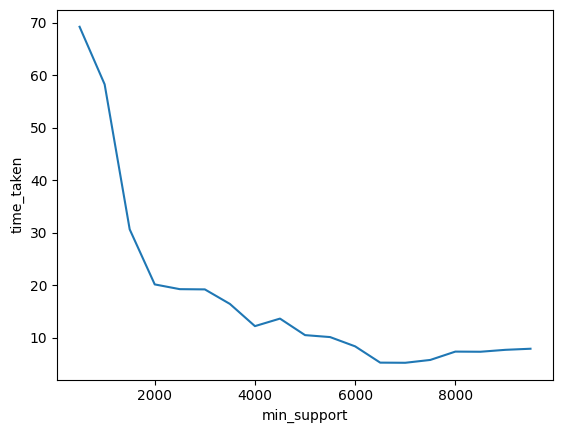

In [11]:
# plot a graph between min_support and time taken
import matplotlib.pyplot as plt
plt.plot(support, time_taken)
plt.xlabel('min_support')
plt.ylabel('time_taken')
plt.show()
